In [ ]:

from dotenv import load_dotenv

load_dotenv('../../.env')
import sys
sys.path.insert(0, '../app')
from processing.image.SIImageDescription import SIImageDescription
from processing.text.SIITranslator import SITranslator
from processing.text.SISurya import SISurya
from S3Storage import S3Storage

s3 = S3Storage()
image_descriptor = SIImageDescription()
translator = SITranslator()
surya = SISurya()



## process single pdf

In [ ]:
from processing.PDFProcessor import PDFProcessor
import os
import glob


pdf_path = "./data/exported_document.pdf"
try:
    pdf = PDFProcessor(image_descriptor, translator, surya, s3, pdf_path)
except Exception as e:
    import traceback
    print("ERROR", e)
    traceback.print_exc()

## process all pdfs

In [ ]:
from processing.PDFProcessor import PDFProcessor
import os

def get_all_pdfs():
    pdf_files = []
    for root, dirs, files in os.walk("./data"):
        for file in files:
            if file.endswith(".pdf"):
                pdf_files.append(os.path.join(root, file))
                # pdf_files.append(os.path.abspath(os.path.join(root, file)))
    return pdf_files

def is_document_already_indexed(pdf_path):
    return False
    # document = client.collections.get("Document")
    # response = document.query.fetch_objects(
    #     filters=(
    #         Filter.by_property("originalPath").equal(pdf_path)
    #     ),
    #     limit=1,
    #     return_properties=[]
    # )
    # return len(response.objects) > 0

pdf_paths = get_all_pdfs()
for pdf_path in pdf_paths:
    # print("==========================================")
    # print(pdf_path)
    if (is_document_already_indexed(pdf_path)):
        print(f"Already in DB, SKIP INDEXING {pdf_path}")
        continue
    pdf = PDFProcessor(image_descriptor, translator, pdf_path)



# test bugs

In [33]:
from pathlib import Path
import os
from typing import List
import fitz
import io
import re
from PIL import Image, ImageFile
from unstructured.partition.pdf import partition_pdf
import shutil
import logging
import numpy as np
from pymupdf import Document as PdfDocument
from schemas import Document, PdfTextChunk, PdfTextMetadata, BoundingBox, PdfImageChunk, PdfImageMetadata
from processing.BaseDocumentProcessor import BaseDocumentProcessor
import uuid

# TODO: check if not causing problems: https://github.com/python-pillow/Pillow/issues/1510
ImageFile.LOAD_TRUNCATED_IMAGES = True
logger = logging.getLogger()

non_space_or_digit_pattern = re.compile(r'[^\s\d]')
class PDFProcessor(BaseDocumentProcessor):
    def __init__(self, image_descriptor: SIImageDescription, translator: SITranslator, surya: SISurya, s3: S3Storage, pdf_path: str, remove_after_upload_to_s3: bool=True):
        self.pdf_path = pdf_path
        print("PDFProcessor pdf_path", pdf_path, flush=True)
        self.image_descriptor = image_descriptor
        self.translator = translator
        self.surya = surya
        self.s3 = s3
        self.remove_after_upload_to_s3 = remove_after_upload_to_s3
        self.base_download_folder = os.path.join(os.getcwd(), 'documents')
        self.id = str(uuid.uuid4())

        # return super().__init__()

    def save_pdf_to_s3(self, pdf_path):
        filename = f"{self.id}.pdf"
        s3ObjectName = os.path.join('pdf', filename)
        self.save_to_s3(self.s3, pdf_path, s3ObjectName, remove=False)
        return s3ObjectName
    
    def unstructured_coordinates_to_bbox(self, coordinates):
        if (not coordinates):
            return False
        x1 = min(coordinates, key=lambda x: x[0])[0]
        y1 = min(coordinates, key=lambda x: x[1])[1]
        x2 = max(coordinates, key=lambda x: x[0])[0]
        y2 = max(coordinates, key=lambda x: x[1])[1]

        return BoundingBox(x1=x1, y1=y1, x2=x2, y2=y2)
    
    def is_single_color(self, image, tolerance=50):
        img_array = np.array(image)
        
        # Reshape the array to 2D (pixels, color channels)
        reshaped = img_array.reshape(-1, img_array.shape[-1])
        
        # Calculate the difference between each pixel and the first pixel
        diff = np.abs(reshaped - reshaped[0])
        
        # Check if all differences are within the tolerance
        return np.all(diff <= tolerance)

    def keep_image_based_on_size(self, width, height):
        aspect_ratio = width / height
        res_megapixel = (width * height) / 1_000_000

        if (res_megapixel < 0.05):
            return False

        # Check if aspect ratio is within an acceptable range
        min_aspect_ratio = 0.2
        max_aspect_ratio = 6
        if aspect_ratio < min_aspect_ratio or aspect_ratio > max_aspect_ratio:
            return False

        return True
    
    def keep_text(self, text:str):
        if (len(text) > 100):
            return True
        return False

    def is_not_only_space_and_number(self, string):
        return bool(non_space_or_digit_pattern.search(string))

    def get_image_from_page(self, doc, page):
        page = doc[page]
        dpi = 72
        zoom = dpi / 72  # 72 is the default DPI
        mat = fitz.Matrix(zoom, zoom)
        pix = page.get_pixmap(matrix=mat)
        img = Image.frombytes("RGB", [pix.width, pix.height], pix.samples)
        return img

    def get_pdf_text_chunks(self, fitz_document: type[PdfDocument], document: Document):
        from PIL import Image, ImageDraw

        images = [self.get_image_from_page(fitz_document, pageNumber) for pageNumber in range(len(fitz_document))]
        result_imgs, result_preds, result_labels = self.surya.process_images(images)
        current_title = ""
        current_subtitle = ""
        chunks: List[PdfTextChunk] = []
        for page_index in range(len(fitz_document)):
            page = fitz_document[page_index]
            preds = result_preds[page_index]
            labels = result_labels[page_index]
            img = result_imgs[page_index]
            
            # Create a copy of the image to draw bounding boxes
            img_with_boxes = img.copy()
            draw = ImageDraw.Draw(img_with_boxes)
            
            # Get page dimensions
            page_width, page_height = img.size
            
            # Calculate margin
            margin_x = page_width * 0.01
            margin_y = page_height * 0.01
            
            # Sort bounding boxes by position
            sorted_indices = sorted(range(len(preds.bboxes)), key=lambda i: preds.bboxes[i].position)
            # Zip and iterate over sorted bounding boxes, labels, and indices
            for i in sorted_indices:
                box = preds.bboxes[i]
                label = labels[i]
                
                left, top, right, bottom = box.bbox
                # Add margin to bbox
                left = max(0, left - margin_x)
                top = max(0, top - margin_y)
                right = min(page_width, right + margin_x)
                bottom = min(page_height, bottom + margin_y)
                
                # Draw bounding box
                draw.rectangle([left, top, right, bottom], outline="red", width=2)
                
                # clean text
                text = self.surya.restructure_text(page.get_text("text", clip=box.bbox))
                text_w_margin = self.surya.restructure_text(page.get_text("text", clip=(left, top, right, bottom)))
                print("TEXT", "\n", text, "\n", text_w_margin)
                print("=-=--=-=-")
                if (label in self.surya.TITLES):
                    current_title = text
                    current_subtitle = ""
                if (label in self.surya.SUB_TITLES):
                    current_subtitle = text

                if (self.keep_text(text) is True and label in self.surya.TEXTS):
                    chunk = PdfTextChunk(
                        document=document,
                        text=text,
                        title=f"{current_title}{'>' + current_subtitle if current_subtitle else ''}",
                        metadata=PdfTextMetadata(
                            pageNumber=page_index+1,
                            bbox=BoundingBox(
                                x1=left, 
                                y1=top, 
                                x2=right, 
                                y2=bottom
                            )
                        )
                    )
                    chunks.append(chunk)                
            # Display the image with bounding boxes
            display(img_with_boxes)

        return chunks
    def save_image(self, image: Image.Image):
        output_folder = os.path.join(self.base_download_folder, "pdf", "images")
        os.makedirs(output_folder, exist_ok=True)
        file_name = f"{self.get_random_uuid()}.png"
        image_path = os.path.join(output_folder, file_name)
        image.save(image_path, "PNG")
        image.close()
        return image_path, file_name


    def get_pdf_images(self, doc: type[PdfDocument]):
        temp_images = []
        logger.info("GET PDF IMAGES logger")

        temp_images = []

        for page_num in range(len(doc)):
            page = doc[page_num]
            
            for img_index, item in enumerate(doc.get_page_images(page_num)):
                try:
                    xref = item[0]
                    base_image = doc.extract_image(xref)
                    
                    if base_image:
                        image_bytes = base_image["image"]
                        image_ext = base_image["ext"]
                        pil_image = Image.open(io.BytesIO(image_bytes))

                        if pil_image.mode != "RGB":
                            pil_image = pil_image.convert("RGB")
                        
                        x0, y0, x1, y1 = page.get_image_bbox(item[7])
                        width = x1 - x0
                        height = y1 - y0
                        if (self.keep_image_based_on_size(width, height) and not self.is_single_color(pil_image)):
                            temp_images.append({
                                "image": pil_image,
                                "pageNumber": page_num + 1,
                                'bbox': {"x0": x0, "y0": y0, "x1": x1, "y1": y1},
                                'format': image_ext
                            })
                        
                
                except Exception as e:
                    print(f"Error processing image {img_index} on page {page_num}: {str(e)}")
                    continue
                                    
        return temp_images


    def extract_document(self):
        print("PDFProcessor extract_document self.pdf_path", self.pdf_path, flush=True)
        mediaName =Path(self.pdf_path).stem


        pdf_s3ObjectName = "self.save_pdf_to_s3(self.pdf_path)"

        document = Document(
            id=self.id,
            originalPath=self.pdf_path,
            s3ObjectName=pdf_s3ObjectName,
            mediaName=mediaName,
        )

        with fitz.open(self.pdf_path) as fitz_doc:

            images = self.get_pdf_images(fitz_doc)
            print("PDFProcessor extract_document images", len(images), flush=True)
            text_chunks = self.get_pdf_text_chunks(fitz_doc, document)
            print("PDFProcessor extract_document texts", len(text_chunks), flush=True)
            images_chunks = [{**image, "description_en": self.image_descriptor.get_description(image['image'])} for image in images]
            # TODO for now deal with error in description ie ;Unsupported number of image dimensions: 2
            images_chunks = [chunk for chunk in images_chunks if chunk['description_en'] is not False]
            translated_images_descriptions = self.translator.en_to_fr_batch([image['description_en'] for image in images_chunks])
            images_with_descriptions = [
                {**image, "description_fr": translated_description}
                for image, translated_description in zip(images_chunks, translated_images_descriptions)
            ]
            
            chunks = []
            # create chunks for every images, and save them to s3
            for img in images_with_descriptions:
                image_path, file_name = self.save_image(img.get('image'))
                image_s3ObjectName = f"{pdf_s3ObjectName}/images/{file_name}"
                self.save_to_s3(self.s3, image_path, image_s3ObjectName)
                img.get('image').close()

                chunk = PdfImageChunk(
                    text=img.get('description_fr'),
                    title="",
                    document=document,
                    metadata=PdfImageMetadata(
                        s3ObjectName=image_s3ObjectName,
                        pageNumber=img.get('pageNumber'),
                        bbox=BoundingBox(
                            x1=img.get('bbox',{}).get('x1', -1), 
                            y1=img.get('bbox',{}).get('x1', -1), 
                            x2=img.get('bbox',{}).get('x1', -1), 
                            y2=img.get('bbox',{}).get('x1', -1)
                        )
                    )
                )
                chunks.append(chunk)
            for text_chunk in text_chunks:
                chunks.append(text_chunk)
    
            # if (self.remove_after_upload_to_s3 is True):
            #     os.remove(self.pdf_path)
            print("RETURNING", document, chunks, flush=True)
            return document, chunks


PDFProcessor pdf_path /home/erwan/Downloads/titre.pdf
PDFProcessor extract_document self.pdf_path /home/erwan/Downloads/titre.pdf
PDFProcessor extract_document images 0


Finding reading order: 100%|██████████| 1/1 [00:00<00:00,  9.87it/s]

TEXT 
 titre 
 titre
=-=--=-=-
TEXT 
 titre bloc 
 titre bloc
=-=--=-=-
TEXT 
 La conférence de Hombourg du 13 février 1918 est un conseil de la couronne impériale allemande convoqué à l'initiative de l'empereur Guillaume II. Réunissant des civils et des militaires, cette rencontre doit permettre de définir la politique du Reich impérial en Russie alors que la suspension d'armes entre le gouvernement russe issu de la révolution d'Octobre et les empires centraux, conclue le 15 décembre 1917, est sur le point d'expirer. 
 La conférence de Hombourg du 13 février 1918 est un conseil de la couronne impériale allemande convoqué à l'initiative de l'empereur Guillaume II. Réunissant des civils et des militaires, cette rencontre doit permettre de définir la politique du Reich impérial en Russie alors que la suspension d'armes entre le gouvernement russe issu de la révolution d'Octobre et les empires centraux, conclue le 15 décembre 1917, est sur le point d'expirer.
=-=--=-=-
TEXT 
 partie 2 
 p

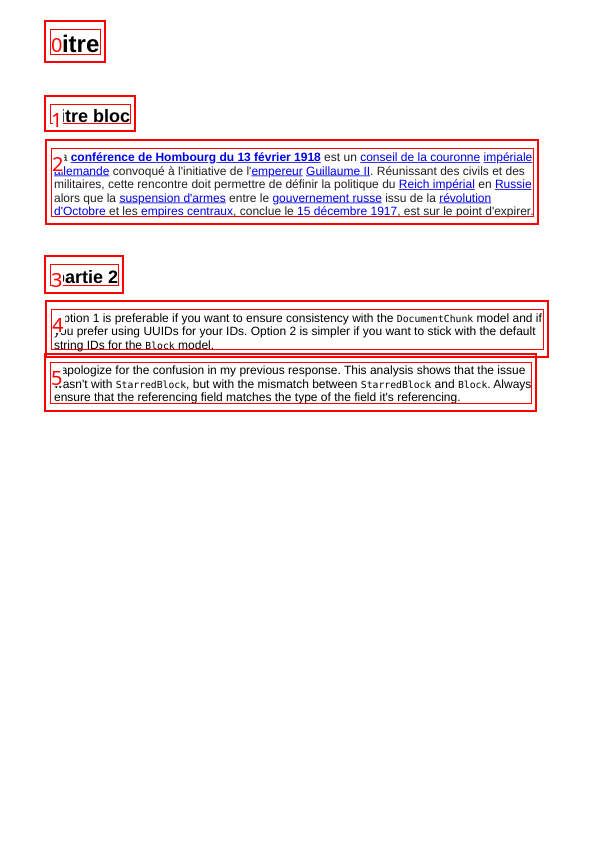

PDFProcessor extract_document texts 3


You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


RETURNING id='ae648ae0-6b35-4bd0-9754-2933516b850d' publicPath='' originalPath='/home/erwan/Downloads/titre.pdf' s3ObjectName='self.save_pdf_to_s3(self.pdf_path)' mediaName='titre' [PdfTextChunk(document=Document(id='ae648ae0-6b35-4bd0-9754-2933516b850d', publicPath='', originalPath='/home/erwan/Downloads/titre.pdf', s3ObjectName='self.save_pdf_to_s3(self.pdf_path)', mediaName='titre'), text="La conférence de Hombourg du 13 février 1918 est un conseil de la couronne impériale allemande convoqué à l'initiative de l'empereur Guillaume II. Réunissant des civils et des militaires, cette rencontre doit permettre de définir la politique du Reich impérial en Russie alors que la suspension d'armes entre le gouvernement russe issu de la révolution d'Octobre et les empires centraux, conclue le 15 décembre 1917, est sur le point d'expirer.", title='>titre bloc', mediaType=<MediaType.PDF_TEXT: 'pdf_text'>, metadata=PdfTextMetadata(pageNumber=1, bbox=BoundingBox(x1=45.04, y1=139.57, x2=538.96, y2=2

In [40]:
from IPython.display import Image 
from dotenv import load_dotenv
load_dotenv('../../.env')
import sys
sys.path.insert(0, '../app')

import io
import fitz
from PIL import Image

pdf_path = "/home/erwan/Downloads/titre.pdf"
# pdf_path = "/home/erwan/Downloads/test_index.pdf"

pdf = PDFProcessor(image_descriptor, translator, surya, s3, pdf_path)
document, chunks = pdf.extract_document()


In [43]:
chunks[0].metadata


PdfTextMetadata(pageNumber=1, bbox=BoundingBox(x1=45.04, y1=139.57, x2=538.96, y2=224.43))